## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [49]:
! pip install warmup_scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2967 sha256=7007b1d5e335b161311ade0e83ee44453ed508db8cdda560162f70aab9de78b2
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [ ]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [ ]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [39]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [ ]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [40]:
import segmentation_models_pytorch as smp

In [41]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [58]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/content/drive/MyDrive/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp034'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'
    backbone = 'timm-mobilenetv3_large_100'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/content/drive/MyDrive/output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    os.makedirs(submission_dir, exist_ok=True)
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'
    os.makedirs(model_dir, exist_ok=True)

    figures_dir = outputs_path + 'figures/'
    os.makedirs(figures_dir, exist_ok=True)


    log_dir = outputs_path + 'logs/'
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:301: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [24]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [25]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [26]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


-------- exp_info -----------------
INFO:__main__:

-------- exp_info -----------------


## image, mask

In [27]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #gray
        # bgr_img = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #BGR
        # image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV) # BGR->HSV

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #gray
    # bgr_mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #BGR
    # mask = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2HSV) # BGR->HSV 
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [28]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [29]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [32]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [33]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [34]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

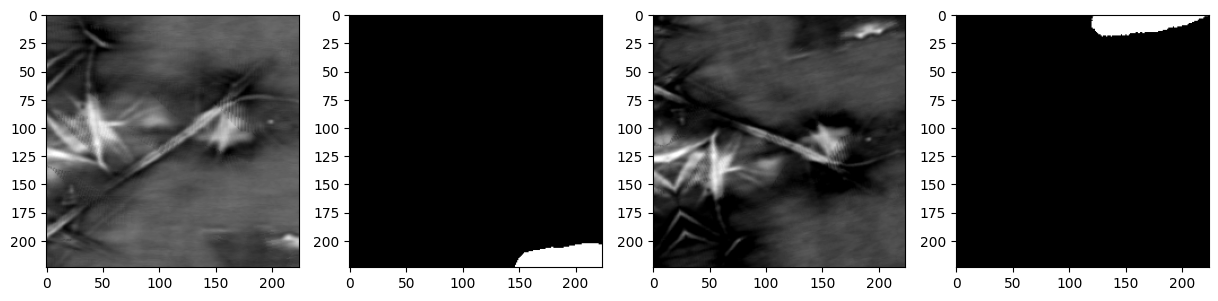

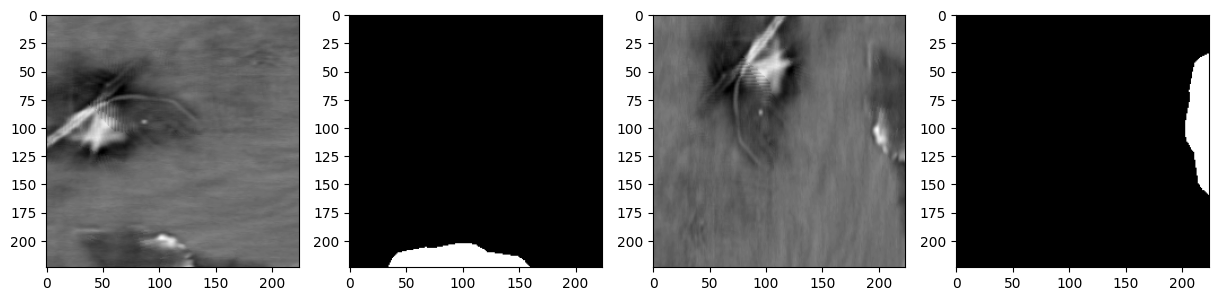

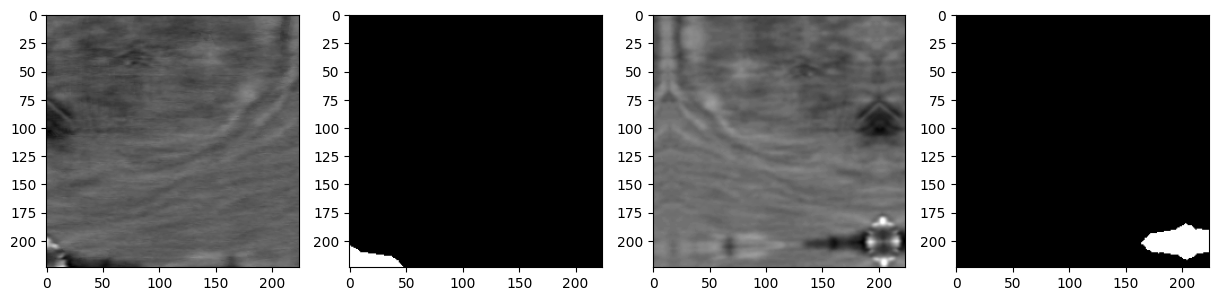

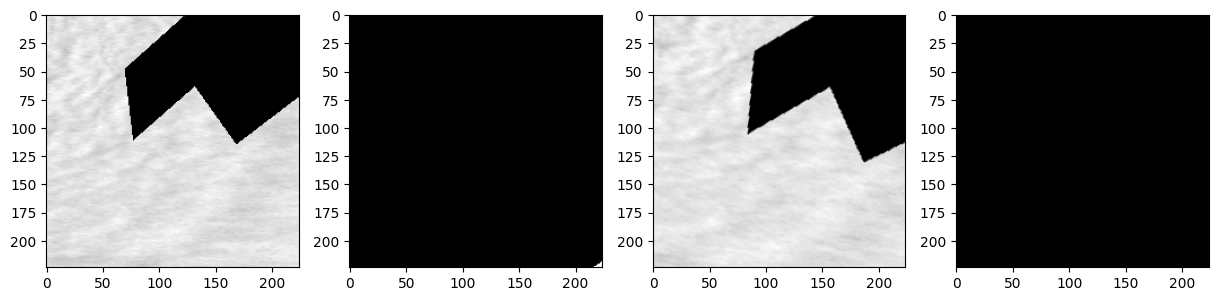

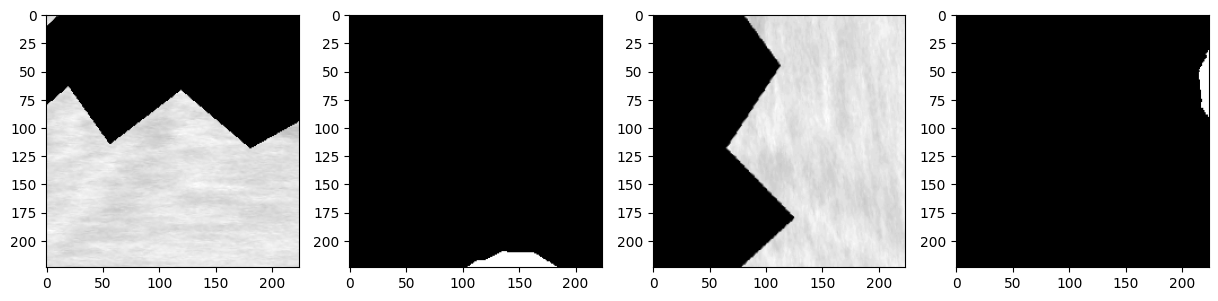

In [44]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [45]:
del plot_dataset
gc.collect()

53899

## model

In [46]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [47]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [50]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [51]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [52]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone timm-mobilenetv3_large_100


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 17.3MB/s]


## loss

In [53]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [54]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [55]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [56]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [ ]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21302215908501318
th: 0.15, fbeta: 0.23315436228104913
th: 0.2, fbeta: 0.2517636676447974
th: 0.25, fbeta: 0.27324406165329534
th: 0.3, fbeta: 0.2844134975971063
th: 0.35, fbeta: 0.2570432761543844
th: 0.4, fbeta: 0.1796330978703178
th: 0.45, fbeta: 0.09606337334007103


best_th: 0.3, fbeta: 0.2844134975971063
best_th: 0.3, fbeta: 0.2844134975971063
INFO:__main__:best_th: 0.3, fbeta: 0.2844134975971063
Epoch 1 - avg_train_loss: 0.3712  avg_val_loss: 0.3000  time: 405s
Epoch 1 - avg_train_loss: 0.3712  avg_val_loss: 0.3000  time: 405s
INFO:__main__:Epoch 1 - avg_train_loss: 0.3712  avg_val_loss: 0.3000  time: 405s
Epoch 1 - avgScore: 0.2844
Epoch 1 - avgScore: 0.2844
INFO:__main__:Epoch 1 - avgScore: 0.2844
Epoch 1 - Save Best Score: 0.2844 Model
Epoch 1 - Save Best Score: 0.2844 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.2844 Model
Epoch 1 - Save Best Loss: 0.3000 Model
Epoch 1 - Save Best Loss: 0.3000 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.3000 Model


th: 0.5, fbeta: 0.045356573900861


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2344587687935062
th: 0.15, fbeta: 0.264318137659564
th: 0.2, fbeta: 0.30935149576510435
th: 0.25, fbeta: 0.35721287827975323
th: 0.3, fbeta: 0.39035924979952186
th: 0.35, fbeta: 0.3965367428226582
th: 0.4, fbeta: 0.3636922083565641
th: 0.45, fbeta: 0.2810592096357862


best_th: 0.35, fbeta: 0.3965367428226582
best_th: 0.35, fbeta: 0.3965367428226582
INFO:__main__:best_th: 0.35, fbeta: 0.3965367428226582
Epoch 2 - avg_train_loss: 0.3184  avg_val_loss: 0.2665  time: 423s
Epoch 2 - avg_train_loss: 0.3184  avg_val_loss: 0.2665  time: 423s
INFO:__main__:Epoch 2 - avg_train_loss: 0.3184  avg_val_loss: 0.2665  time: 423s
Epoch 2 - avgScore: 0.3965
Epoch 2 - avgScore: 0.3965
INFO:__main__:Epoch 2 - avgScore: 0.3965
Epoch 2 - Save Best Score: 0.3965 Model
Epoch 2 - Save Best Score: 0.3965 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.3965 Model
Epoch 2 - Save Best Loss: 0.2665 Model
Epoch 2 - Save Best Loss: 0.2665 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.2665 Model


th: 0.5, fbeta: 0.17291503291924284


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.290563621096489
th: 0.15, fbeta: 0.32420489137809255
th: 0.2, fbeta: 0.34923665547484883
th: 0.25, fbeta: 0.3690519047324584
th: 0.3, fbeta: 0.38318689590594274
th: 0.35, fbeta: 0.3880180894013325
th: 0.4, fbeta: 0.3814633973484055
th: 0.45, fbeta: 0.3636202018720329


best_th: 0.35, fbeta: 0.3880180894013325
best_th: 0.35, fbeta: 0.3880180894013325
INFO:__main__:best_th: 0.35, fbeta: 0.3880180894013325
Epoch 3 - avg_train_loss: 0.2785  avg_val_loss: 0.2479  time: 441s
Epoch 3 - avg_train_loss: 0.2785  avg_val_loss: 0.2479  time: 441s
INFO:__main__:Epoch 3 - avg_train_loss: 0.2785  avg_val_loss: 0.2479  time: 441s
Epoch 3 - avgScore: 0.3880
Epoch 3 - avgScore: 0.3880
INFO:__main__:Epoch 3 - avgScore: 0.3880


th: 0.5, fbeta: 0.33085003676960906


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29147503580160045
th: 0.15, fbeta: 0.3227196605955595
th: 0.2, fbeta: 0.34299434938348927
th: 0.25, fbeta: 0.3616747246042872
th: 0.3, fbeta: 0.3782918844051596
th: 0.35, fbeta: 0.39092414215410365
th: 0.4, fbeta: 0.39560169066324047
th: 0.45, fbeta: 0.3966343027338469


best_th: 0.45, fbeta: 0.3966343027338469
best_th: 0.45, fbeta: 0.3966343027338469
INFO:__main__:best_th: 0.45, fbeta: 0.3966343027338469
Epoch 4 - avg_train_loss: 0.2563  avg_val_loss: 0.2578  time: 489s
Epoch 4 - avg_train_loss: 0.2563  avg_val_loss: 0.2578  time: 489s
INFO:__main__:Epoch 4 - avg_train_loss: 0.2563  avg_val_loss: 0.2578  time: 489s
Epoch 4 - avgScore: 0.3966
Epoch 4 - avgScore: 0.3966
INFO:__main__:Epoch 4 - avgScore: 0.3966
Epoch 4 - Save Best Score: 0.3966 Model
Epoch 4 - Save Best Score: 0.3966 Model
INFO:__main__:Epoch 4 - Save Best Score: 0.3966 Model
Epoch 4 - Save Best Loss: 0.2578 Model
Epoch 4 - Save Best Loss: 0.2578 Model
INFO:__main__:Epoch 4 - Save Best Loss: 0.2578 Model


th: 0.5, fbeta: 0.3931768358195461


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3098913879595455
th: 0.15, fbeta: 0.3373951668702416
th: 0.2, fbeta: 0.3637022910011644
th: 0.25, fbeta: 0.38637932299157546
th: 0.3, fbeta: 0.4091804329502517
th: 0.35, fbeta: 0.4255836931106539
th: 0.4, fbeta: 0.4327925084736528
th: 0.45, fbeta: 0.42838734879866586


best_th: 0.4, fbeta: 0.4327925084736528
best_th: 0.4, fbeta: 0.4327925084736528
INFO:__main__:best_th: 0.4, fbeta: 0.4327925084736528
Epoch 5 - avg_train_loss: 0.2459  avg_val_loss: 0.2471  time: 473s
Epoch 5 - avg_train_loss: 0.2459  avg_val_loss: 0.2471  time: 473s
INFO:__main__:Epoch 5 - avg_train_loss: 0.2459  avg_val_loss: 0.2471  time: 473s
Epoch 5 - avgScore: 0.4328
Epoch 5 - avgScore: 0.4328
INFO:__main__:Epoch 5 - avgScore: 0.4328
Epoch 5 - Save Best Score: 0.4328 Model
Epoch 5 - Save Best Score: 0.4328 Model
INFO:__main__:Epoch 5 - Save Best Score: 0.4328 Model
Epoch 5 - Save Best Loss: 0.2471 Model
Epoch 5 - Save Best Loss: 0.2471 Model
INFO:__main__:Epoch 5 - Save Best Loss: 0.2471 Model


th: 0.5, fbeta: 0.4167565519666411


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3171475072810302
th: 0.15, fbeta: 0.35350629629078056
th: 0.2, fbeta: 0.37989543350941807
th: 0.25, fbeta: 0.4012535842463103
th: 0.3, fbeta: 0.42176461018894407
th: 0.35, fbeta: 0.43933818029455035
th: 0.4, fbeta: 0.44875086692014243
th: 0.45, fbeta: 0.4437194038967939


best_th: 0.4, fbeta: 0.44875086692014243
best_th: 0.4, fbeta: 0.44875086692014243
INFO:__main__:best_th: 0.4, fbeta: 0.44875086692014243
Epoch 6 - avg_train_loss: 0.2349  avg_val_loss: 0.2402  time: 488s
Epoch 6 - avg_train_loss: 0.2349  avg_val_loss: 0.2402  time: 488s
INFO:__main__:Epoch 6 - avg_train_loss: 0.2349  avg_val_loss: 0.2402  time: 488s
Epoch 6 - avgScore: 0.4488
Epoch 6 - avgScore: 0.4488
INFO:__main__:Epoch 6 - avgScore: 0.4488
Epoch 6 - Save Best Score: 0.4488 Model
Epoch 6 - Save Best Score: 0.4488 Model
INFO:__main__:Epoch 6 - Save Best Score: 0.4488 Model
Epoch 6 - Save Best Loss: 0.2402 Model
Epoch 6 - Save Best Loss: 0.2402 Model
INFO:__main__:Epoch 6 - Save Best Loss: 0.2402 Model


th: 0.5, fbeta: 0.42114653739786956


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3600718564220615
th: 0.15, fbeta: 0.40210509012967227
th: 0.2, fbeta: 0.43583707454229165
th: 0.25, fbeta: 0.45816193766616364
th: 0.3, fbeta: 0.4739502815169092
th: 0.35, fbeta: 0.48446448777882695
th: 0.4, fbeta: 0.4874052806627516
th: 0.45, fbeta: 0.4778042172243987


best_th: 0.4, fbeta: 0.4874052806627516
best_th: 0.4, fbeta: 0.4874052806627516
INFO:__main__:best_th: 0.4, fbeta: 0.4874052806627516
Epoch 7 - avg_train_loss: 0.2269  avg_val_loss: 0.2470  time: 500s
Epoch 7 - avg_train_loss: 0.2269  avg_val_loss: 0.2470  time: 500s
INFO:__main__:Epoch 7 - avg_train_loss: 0.2269  avg_val_loss: 0.2470  time: 500s
Epoch 7 - avgScore: 0.4874
Epoch 7 - avgScore: 0.4874
INFO:__main__:Epoch 7 - avgScore: 0.4874
Epoch 7 - Save Best Score: 0.4874 Model
Epoch 7 - Save Best Score: 0.4874 Model
INFO:__main__:Epoch 7 - Save Best Score: 0.4874 Model
Epoch 7 - Save Best Loss: 0.2470 Model
Epoch 7 - Save Best Loss: 0.2470 Model
INFO:__main__:Epoch 7 - Save Best Loss: 0.2470 Model


th: 0.5, fbeta: 0.4552816628180161


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36349865272628495
th: 0.15, fbeta: 0.40415665642668314
th: 0.2, fbeta: 0.4421533554175633
th: 0.25, fbeta: 0.47327587285896755
th: 0.3, fbeta: 0.49390032408325873
th: 0.35, fbeta: 0.5075083692922451
th: 0.4, fbeta: 0.5160841928709615
th: 0.45, fbeta: 0.5190760001064504


best_th: 0.45, fbeta: 0.5190760001064504
best_th: 0.45, fbeta: 0.5190760001064504
INFO:__main__:best_th: 0.45, fbeta: 0.5190760001064504
Epoch 8 - avg_train_loss: 0.2223  avg_val_loss: 0.2303  time: 533s
Epoch 8 - avg_train_loss: 0.2223  avg_val_loss: 0.2303  time: 533s
INFO:__main__:Epoch 8 - avg_train_loss: 0.2223  avg_val_loss: 0.2303  time: 533s
Epoch 8 - avgScore: 0.5191
Epoch 8 - avgScore: 0.5191
INFO:__main__:Epoch 8 - avgScore: 0.5191
Epoch 8 - Save Best Score: 0.5191 Model
Epoch 8 - Save Best Score: 0.5191 Model
INFO:__main__:Epoch 8 - Save Best Score: 0.5191 Model
Epoch 8 - Save Best Loss: 0.2303 Model
Epoch 8 - Save Best Loss: 0.2303 Model
INFO:__main__:Epoch 8 - Save Best Loss: 0.2303 Model


th: 0.5, fbeta: 0.5149196960243916


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3419332629210774
th: 0.15, fbeta: 0.3703893827789006
th: 0.2, fbeta: 0.39624317787655233
th: 0.25, fbeta: 0.4191750184548593
th: 0.3, fbeta: 0.4420100455159839
th: 0.35, fbeta: 0.46079758148506567
th: 0.4, fbeta: 0.4749157105415198
th: 0.45, fbeta: 0.48275091749305865


best_th: 0.5, fbeta: 0.4827821018733998
best_th: 0.5, fbeta: 0.4827821018733998
INFO:__main__:best_th: 0.5, fbeta: 0.4827821018733998
Epoch 9 - avg_train_loss: 0.2150  avg_val_loss: 0.2470  time: 544s
Epoch 9 - avg_train_loss: 0.2150  avg_val_loss: 0.2470  time: 544s
INFO:__main__:Epoch 9 - avg_train_loss: 0.2150  avg_val_loss: 0.2470  time: 544s
Epoch 9 - avgScore: 0.4828
Epoch 9 - avgScore: 0.4828
INFO:__main__:Epoch 9 - avgScore: 0.4828


th: 0.5, fbeta: 0.4827821018733998


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37444011208858374
th: 0.15, fbeta: 0.402952395816859
th: 0.2, fbeta: 0.4278517424099212
th: 0.25, fbeta: 0.4483307903545042
th: 0.3, fbeta: 0.463150165119285
th: 0.35, fbeta: 0.47568218725775674
th: 0.4, fbeta: 0.4822314844796049
th: 0.45, fbeta: 0.48594487647303014


best_th: 0.5, fbeta: 0.4864078237444685
best_th: 0.5, fbeta: 0.4864078237444685
INFO:__main__:best_th: 0.5, fbeta: 0.4864078237444685
Epoch 10 - avg_train_loss: 0.2068  avg_val_loss: 0.2596  time: 695s
Epoch 10 - avg_train_loss: 0.2068  avg_val_loss: 0.2596  time: 695s
INFO:__main__:Epoch 10 - avg_train_loss: 0.2068  avg_val_loss: 0.2596  time: 695s
Epoch 10 - avgScore: 0.4864
Epoch 10 - avgScore: 0.4864
INFO:__main__:Epoch 10 - avgScore: 0.4864


th: 0.5, fbeta: 0.4864078237444685


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4058834896046616
th: 0.15, fbeta: 0.44350601470936996
th: 0.2, fbeta: 0.46479669014614483
th: 0.25, fbeta: 0.465566784440169
th: 0.3, fbeta: 0.45877239975537387
th: 0.35, fbeta: 0.44376971807599674
th: 0.4, fbeta: 0.4229934069401021
th: 0.45, fbeta: 0.39855222232730136


best_th: 0.25, fbeta: 0.465566784440169
best_th: 0.25, fbeta: 0.465566784440169
INFO:__main__:best_th: 0.25, fbeta: 0.465566784440169
Epoch 11 - avg_train_loss: 0.2002  avg_val_loss: 0.2818  time: 770s
Epoch 11 - avg_train_loss: 0.2002  avg_val_loss: 0.2818  time: 770s
INFO:__main__:Epoch 11 - avg_train_loss: 0.2002  avg_val_loss: 0.2818  time: 770s
Epoch 11 - avgScore: 0.4656
Epoch 11 - avgScore: 0.4656
INFO:__main__:Epoch 11 - avgScore: 0.4656


th: 0.5, fbeta: 0.3661783321836162


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3707466648859784
th: 0.15, fbeta: 0.4013610918714963
th: 0.2, fbeta: 0.4249818197825424
th: 0.25, fbeta: 0.4432985268346439
th: 0.3, fbeta: 0.45506744249328995
th: 0.35, fbeta: 0.4645693757659462
th: 0.4, fbeta: 0.4721837621593789
th: 0.45, fbeta: 0.47802655866016436


best_th: 0.5, fbeta: 0.4810621248143055
best_th: 0.5, fbeta: 0.4810621248143055
INFO:__main__:best_th: 0.5, fbeta: 0.4810621248143055
Epoch 12 - avg_train_loss: 0.1933  avg_val_loss: 0.2554  time: 790s
Epoch 12 - avg_train_loss: 0.1933  avg_val_loss: 0.2554  time: 790s
INFO:__main__:Epoch 12 - avg_train_loss: 0.1933  avg_val_loss: 0.2554  time: 790s
Epoch 12 - avgScore: 0.4811
Epoch 12 - avgScore: 0.4811
INFO:__main__:Epoch 12 - avgScore: 0.4811


th: 0.5, fbeta: 0.4810621248143055


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3491549237317206
th: 0.15, fbeta: 0.37897496757536064
th: 0.2, fbeta: 0.40311840415710903
th: 0.25, fbeta: 0.42425879215577256
th: 0.3, fbeta: 0.4430945860392953
th: 0.35, fbeta: 0.45684703596609455
th: 0.4, fbeta: 0.46979450947178775
th: 0.45, fbeta: 0.47927021520639856


best_th: 0.5, fbeta: 0.4839316412206223
best_th: 0.5, fbeta: 0.4839316412206223
INFO:__main__:best_th: 0.5, fbeta: 0.4839316412206223
Epoch 13 - avg_train_loss: 0.1880  avg_val_loss: 0.2538  time: 752s
Epoch 13 - avg_train_loss: 0.1880  avg_val_loss: 0.2538  time: 752s
INFO:__main__:Epoch 13 - avg_train_loss: 0.1880  avg_val_loss: 0.2538  time: 752s
Epoch 13 - avgScore: 0.4839
Epoch 13 - avgScore: 0.4839
INFO:__main__:Epoch 13 - avgScore: 0.4839


th: 0.5, fbeta: 0.4839316412206223


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36210795108835075
th: 0.15, fbeta: 0.39447050097522596
th: 0.2, fbeta: 0.4193582276156116
th: 0.25, fbeta: 0.44026851982643506
th: 0.3, fbeta: 0.4584370209521798
th: 0.35, fbeta: 0.47366795791327865
th: 0.4, fbeta: 0.4859768601837955
th: 0.45, fbeta: 0.49501834222324964


best_th: 0.5, fbeta: 0.4969431696603842
best_th: 0.5, fbeta: 0.4969431696603842
INFO:__main__:best_th: 0.5, fbeta: 0.4969431696603842
Epoch 14 - avg_train_loss: 0.1784  avg_val_loss: 0.2533  time: 770s
Epoch 14 - avg_train_loss: 0.1784  avg_val_loss: 0.2533  time: 770s
INFO:__main__:Epoch 14 - avg_train_loss: 0.1784  avg_val_loss: 0.2533  time: 770s
Epoch 14 - avgScore: 0.4969
Epoch 14 - avgScore: 0.4969
INFO:__main__:Epoch 14 - avgScore: 0.4969


th: 0.5, fbeta: 0.4969431696603842


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41695693610268875
th: 0.15, fbeta: 0.4377205155649246
th: 0.2, fbeta: 0.4551501163559075
th: 0.25, fbeta: 0.46660990911017924


In [ ]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [ ]:
mask_pred = check_point['preds']

In [ ]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

In [ ]:
plt.hist(mask_pred.flatten(), bins=20)